In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import yfinance as yf
import keras 
import os
import tensorflow
import datetime 
import requests
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [25]:
class DataPrep():
    def __init__(self,ticker,daysago,split):
        self.ticker = ticker.upper()
        self.daysago = daysago

        
        df = yf.Ticker(ticker.upper()).history(period='max')
        df = df[['Close']]
        for i in range(daysago,-2,-1):
            df[f'{i}daysago'] = df['Close'].shift(i)
        df = df.drop(columns=['Close'])
        df = df.dropna()
        self.df = df
        
        #scales the data, splits into train and test
        self.sc = MinMaxScaler()
        self.split = int(len(self.df)*split)
        self.fitted = self.sc.fit_transform(self.df)
    def X_train(self):
        return self.fitted[:,:self.daysago+1][:self.split].reshape((-1,self.daysago+1,1))
    def X_test(self):
        return self.fitted[:,:self.daysago+1][self.split:].reshape((-1,self.daysago+1,1))
    def Y_train(self):  
        return self.fitted[:,-1][:self.split].reshape((-1,1))
    def Y_test(self):
        return self.fitted[:,-1][self.split:].reshape((-1,1))

data = DataPrep('aapl',100,0.9)



array([ 68.8706665 ,  67.75431824,  69.97972107, ..., 226.83999634,
       227.17999268, 225.67999268])

In [3]:
#takes the name of a csv file and returns a list of tickers, with an optional blacklist
def ReadIndex(filename='SP500',blacklist=['BRK.B','BF.B','WRK','SOLV','GEV','SWKS']):
    df = pd.read_csv(f'{filename}.csv')
    ListOfTickers = df['Symbol'].tolist()
    for ticker in blacklist:
        ListOfTickers.remove(ticker)
    return ListOfTickers

ReadIndex()

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BK',
 'BBWI',
 'BAX',
 'BDX',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BLDR',
 'BG',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'COR',
 'CNC',
 'CNP',
 'CF',
 'CHRW',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'COP',
 

In [27]:
#takes the full list of tickers and a SINGLE metric, returns a grouped object of the metric, ranked by quantiles
metricsIWannaTest = ['state', 'industryKey', 'sectorKey', 'fullTimeEmployees', 'companyOfficers', 'auditRisk', 'boardRisk', 'compensationRisk', 'shareHolderRightsRisk', 'overallRisk', 'maxAge', 'priceHint', 'previousClose', 'open', 'dayLow', 'dayHigh', 'regularMarketPreviousClose', 'regularMarketOpen', 'regularMarketDayLow', 'regularMarketDayHigh', 'dividendRate', 'dividendYield', 'payoutRatio', 'fiveYearAvgDividendYield', 'beta', 'trailingPE', 'forwardPE', 'volume', 'regularMarketVolume', 'averageVolume', 'averageVolume10days', 'averageDailyVolume10Day', 'bid', 'ask', 'bidSize', 'askSize', 'marketCap', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'priceToSalesTrailing12Months', 'fiftyDayAverage', 'twoHundredDayAverage', 'trailingAnnualDividendRate', 'trailingAnnualDividendYield', 'enterpriseValue', 'profitMargins', 'floatShares', 'sharesOutstanding', 'sharesShort', 'sharesShortPriorMonth', 'sharesShortPreviousMonthDate', 'dateShortInterest', 'sharesPercentSharesOut', 'heldPercentInsiders', 'heldPercentInstitutions', 'shortRatio', 'shortPercentOfFloat', 'impliedSharesOutstanding', 'bookValue', 'priceToBook', 'mostRecentQuarter', 'earningsQuarterlyGrowth', 'netIncomeToCommon', 'trailingEps', 'forwardEps', 'pegRatio', 'lastSplitFactor', 'enterpriseToRevenue', 'enterpriseToEbitda', '52WeekChange', 'SandP52WeekChange', 'lastDividendValue', 'lastDividendDate', 'currentPrice', 'targetHighPrice', 'targetLowPrice', 'targetMeanPrice', 'targetMedianPrice', 'recommendationMean', 'numberOfAnalystOpinions', 'totalCash', 'totalCashPerShare', 'ebitda', 'totalDebt', 'quickRatio', 'currentRatio', 'totalRevenue', 'debtToEquity', 'revenuePerShare', 'returnOnAssets', 'returnOnEquity', 'freeCashflow', 'operatingCashflow', 'earningsGrowth', 'revenueGrowth', 'grossMargins', 'ebitdaMargins', 'operatingMargins', 'trailingPegRatio']
def getIndexMetric(listOfTickers, metric):

    #initializes empty array, for metric info
    metricinfo = []

    #loops through tickers and appends the metric info to the array
    for ticker in listOfTickers:
        print(ticker)
        metricinfo.append(yf.Ticker(ticker).info[metric])
    
    #converts the array to a df, groups by quantiles
    metricinfo = pd.DataFrame(metricinfo,columns=[f'{metric}'],index=ReadIndex())
    metricinfo = metricinfo.groupby(pd.qcut(metricinfo[f'{metric}'], q=10),observed=False)
    listOfTickers = []
    for group_name, group_data in metricinfo: 
        listOfTickers.append(group_data.index.tolist())
    return listOfTickers
e= getIndexMetric(ReadIndex(), 'marketCap')


MMM
AOS
ABT
ABBV
ACN
ADBE
AMD
AES
AFL
A
APD
ABNB
AKAM
ALB
ARE
ALGN
ALLE
LNT
ALL
GOOGL
GOOG
MO
AMZN
AMCR
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
AME
AMGN
APH
ADI
ANSS
AON
APA
AAPL
AMAT
APTV
ACGL
ADM
ANET
AJG
AIZ
T
ATO
ADSK
ADP
AZO
AVB
AVY
AXON
BKR
BALL
BAC
BK
BBWI
BAX
BDX
BBY
BIO
TECH
BIIB
BLK
BX
BA
BKNG
BWA
BXP
BSX
BMY
AVGO
BR
BRO
BLDR
BG
CDNS
CZR
CPT
CPB
COF
CAH
KMX
CCL
CARR
CTLT
CAT
CBOE
CBRE
CDW
CE
COR
CNC
CNP
CF
CHRW
CRL
SCHW
CHTR
CVX
CMG
CB
CHD
CI
CINF
CTAS
CSCO
C
CFG
CLX
CME
CMS
KO
CTSH
CL
CMCSA
CMA
CAG
COP
ED
STZ
CEG
COO
CPRT
GLW
CPAY
CTVA
CSGP
COST
CTRA
CCI
CSX
CMI
CVS
DHR
DRI
DVA
DAY
DECK
DE
DAL
DVN
DXCM
FANG
DLR
DFS
DG
DLTR
D
DPZ
DOV
DOW
DHI
DTE
DUK
DD
EMN
ETN
EBAY
ECL
EIX
EW
EA
ELV
LLY
EMR
ENPH
ETR
EOG
EPAM
EQT
EFX
EQIX
EQR
ESS
EL
ETSY
EG
EVRG
ES
EXC
EXPE
EXPD
EXR
XOM
FFIV
FDS
FICO
FAST
FRT
FDX
FIS
FITB
FSLR
FE
FI
FMC
F
FTNT
FTV
FOXA
FOX
BEN
FCX
GRMN
IT
GE
GEHC
GEN
GNRC
GD
GIS
GM
GPC
GILD
GPN
GL
GS
HAL
HIG
HAS
HCA
DOC
HSIC
HSY
HES
HPE
HLT
HOLX
HD
HON
HRL
HST
HWM
HPQ
HUBB
HUM
HBAN
HI

In [73]:
#takes the grouped object of a metric and returns a dictionary of train/test data for each quantile
def TrainData(listOfRankedTickers,metric,daysago=100,split=0.9):
    for listOfTickers in listOfRankedTickers:
        boxStart = listOfRankedTickers.index(listOfTickers)
        #this if statement is for run select quantiles that bugged out, and need
        #to be retrained
        if True:
            modelName = f'{boxStart*10}%-{(boxStart+1)*10}% quantile'
            print(modelName)
            X_train,Y_train = np.array([]).reshape(-1,daysago+1,1),np.array([]).reshape(-1,1)
            for ticker in listOfTickers:
                print(ticker)
                data = DataPrep(ticker,daysago,split)
                X_train = np.append(X_train,data.X_train(),axis=0)
                Y_train = np.append(Y_train,data.Y_train(),axis=0)
            model = Sequential()
            model.add(InputLayer((daysago+1, 1)))
            model.add(LSTM(66))
            model.add(Dense(33, 'sigmoid'))
            model.add(Dense(1, 'linear'))
            model.compile(loss='mse',optimizer=Adam(learning_rate=0.001), metrics=['mse'])
            cp1 = ModelCheckpoint(f'models/{metric}/{modelName}.keras', save_best_only=False)
            model.fit(X_train, Y_train, epochs=5, batch_size=32, callbacks=[cp1])
    return X_train.shape,Y_train.shape
# TrainData(e,'marketCap',100,0.99)

70%-80% quantile
MMM
ABNB
MO
APH
AON
BDX
BMY
CDNS
CARR
CMG
CTAS
CME
CL
CSX
CVS
DUK
ECL
EOG
EQIX
FDX
FI
FCX
GD
GILD
ITW
INTC
ICE
MCK
MDLZ
MCO
MSI
NOC
NXPI
ORLY
PH
PYPL
PNC
RSG
SLB
SHW
SO
SNPS
TGT
TT
TDG
USB
WM
WELL
ZTS
ZTS
Epoch 1/5
14277/14277 ━━━━━━━━━━━━━━━━━━━━ 353s 24ms/step - loss: 9.5444e-04 - mse: 9.5444e-04
Epoch 2/5
14277/14277 ━━━━━━━━━━━━━━━━━━━━ 330s 23ms/step - loss: 4.0525e-05 - mse: 4.0525e-05
Epoch 3/5
14277/14277 ━━━━━━━━━━━━━━━━━━━━ 331s 23ms/step - loss: 4.0239e-05 - mse: 4.0239e-05
Epoch 4/5
14277/14277 ━━━━━━━━━━━━━━━━━━━━ 333s 23ms/step - loss: 3.8477e-05 - mse: 3.8477e-05
Epoch 5/5
14277/14277 ━━━━━━━━━━━━━━━━━━━━ 331s 23ms/step - loss: 3.8323e-05 - mse: 3.8323e-05
80%-90% quantile
AMT
ADI
AMAT
ANET
T
ADP
BLK
BA
BKNG
BSX
CAT
SCHW
CB
CI
C
CMCSA
COP
DE
ETN
ELV
GS
HCA
HON
ISRG
KLAC
LRCX
LMT
LOW
MMC
MDT
MU
MS
NEE
NKE
PANW
PFE
PGR
PLD
RTX
REGN
SPGI
NOW
SBUX
SYK
TJX
UBER
UNP
UPS
VRTX
DIS
Epoch 1/5
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 357s 24ms/step - loss: 5.1808e-04 - mse

((478118, 101, 1), (478118, 1))

0%-10% quantile
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

(               0
 0     112.473197
 1     113.231693
 2     111.481884
 3     111.487184
 4     110.509340
 ...          ...
 4849   56.522878
 4850   55.885551
 4851   56.430317
 4852   57.146814
 4853   57.142458
 
 [4854 rows x 1 columns],
                0
 0     112.007332
 1     110.364235
 2     110.374138
 3     109.443710
 4     108.889420
 ...          ...
 4849   55.459999
 4850   55.959999
 4851   56.700001
 4852   56.720001
 4853   56.259998
 
 [4854 rows x 1 columns])

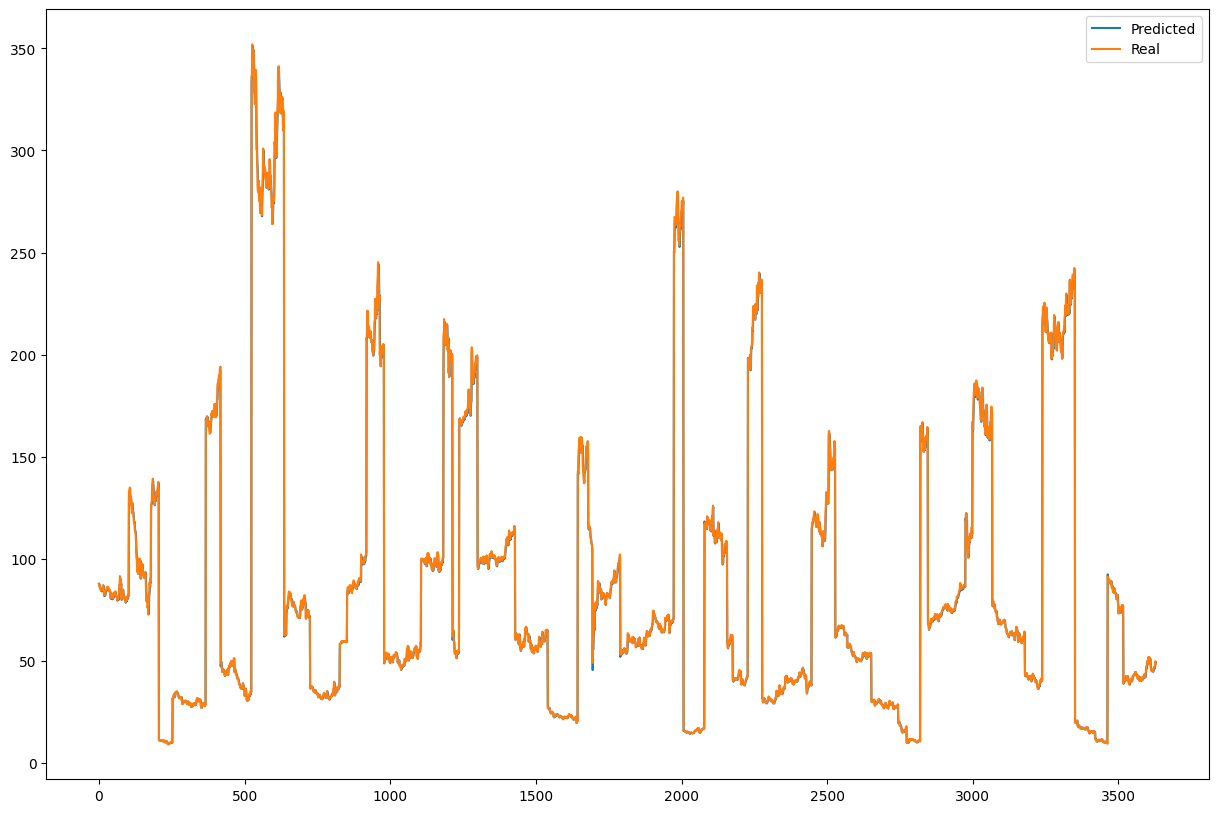

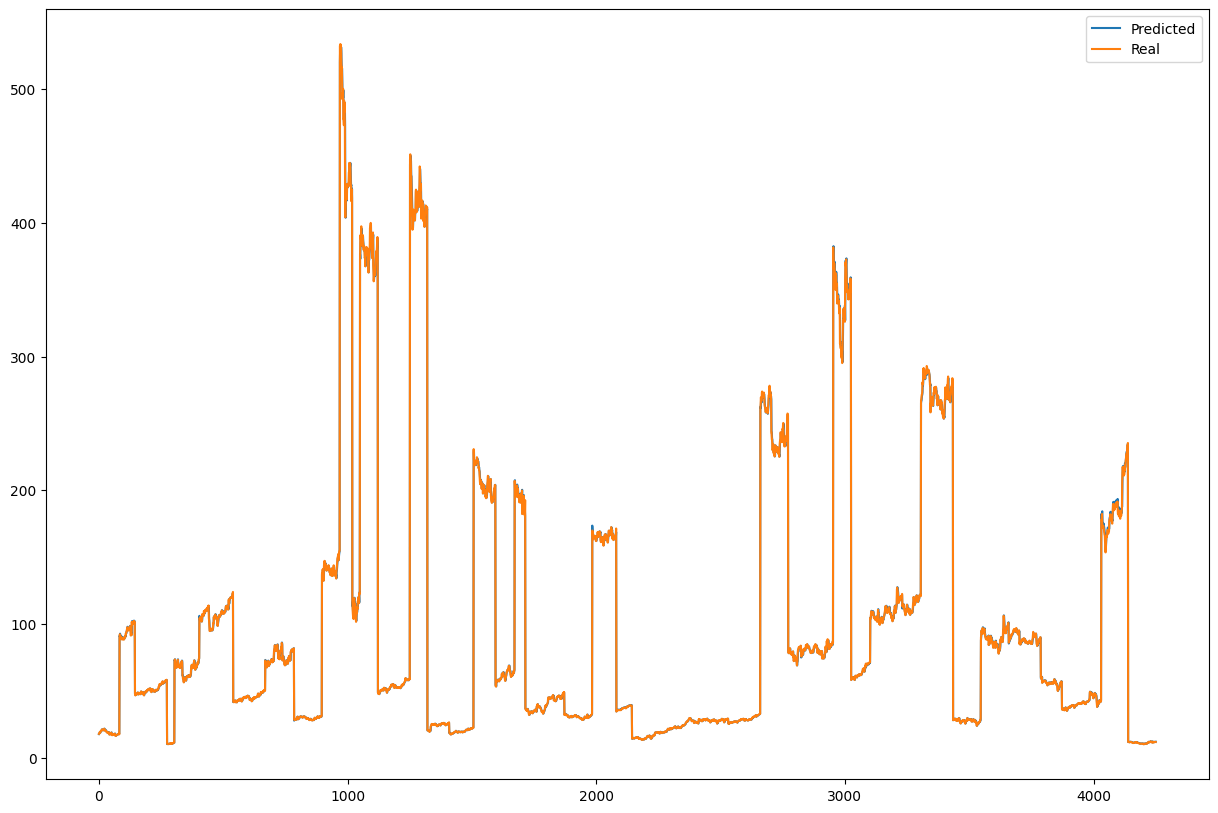

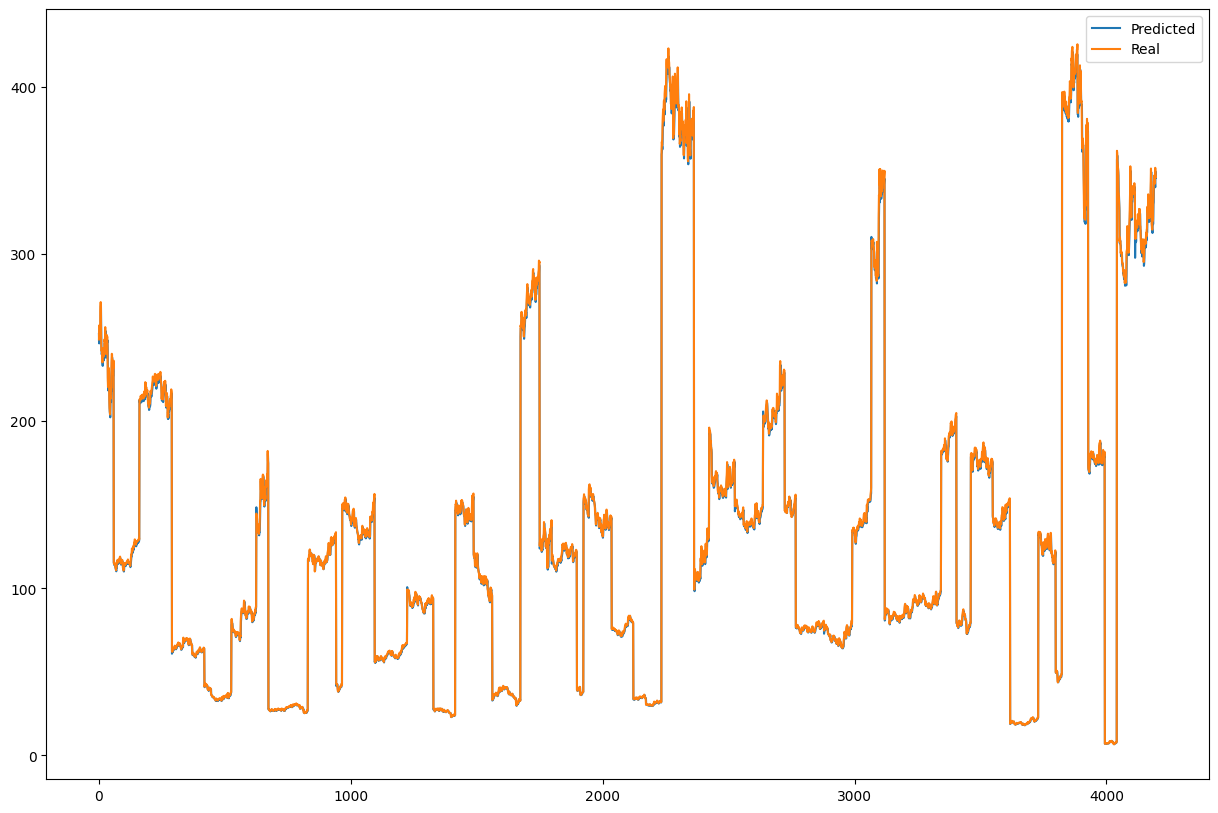

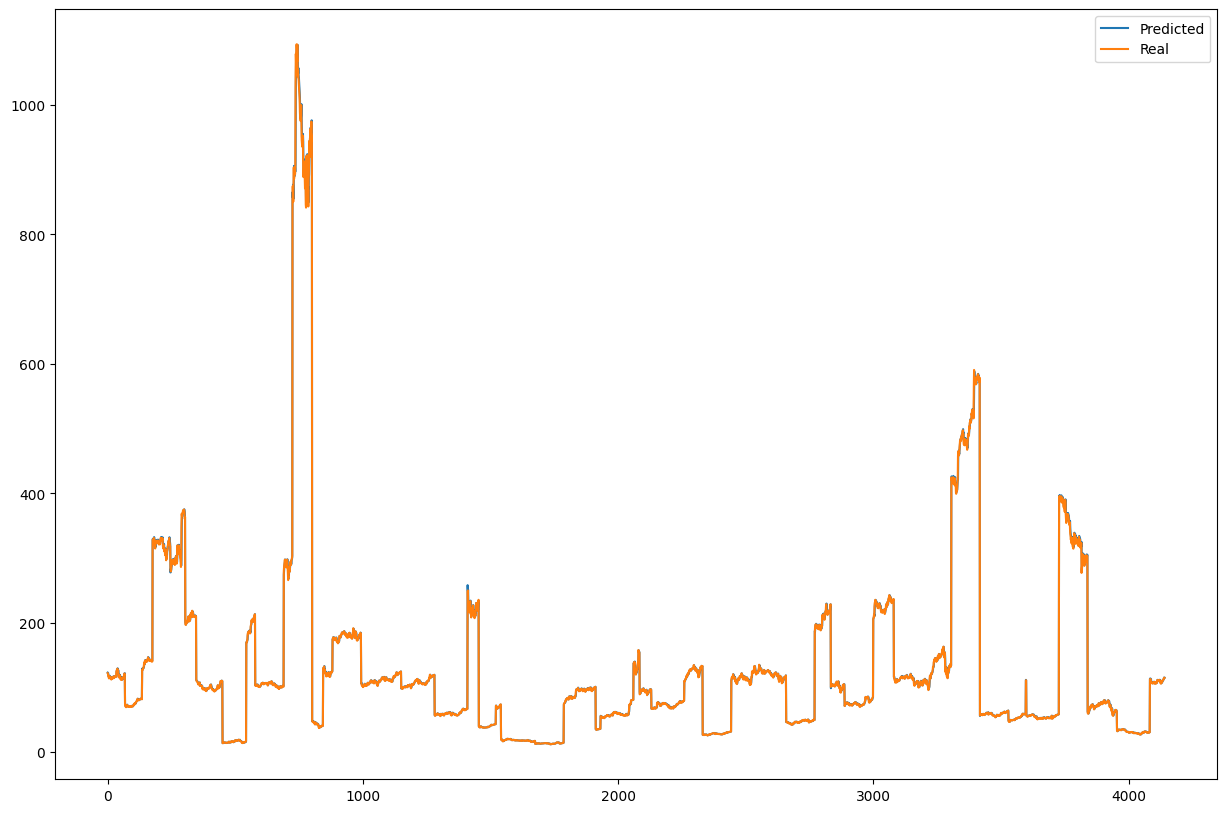

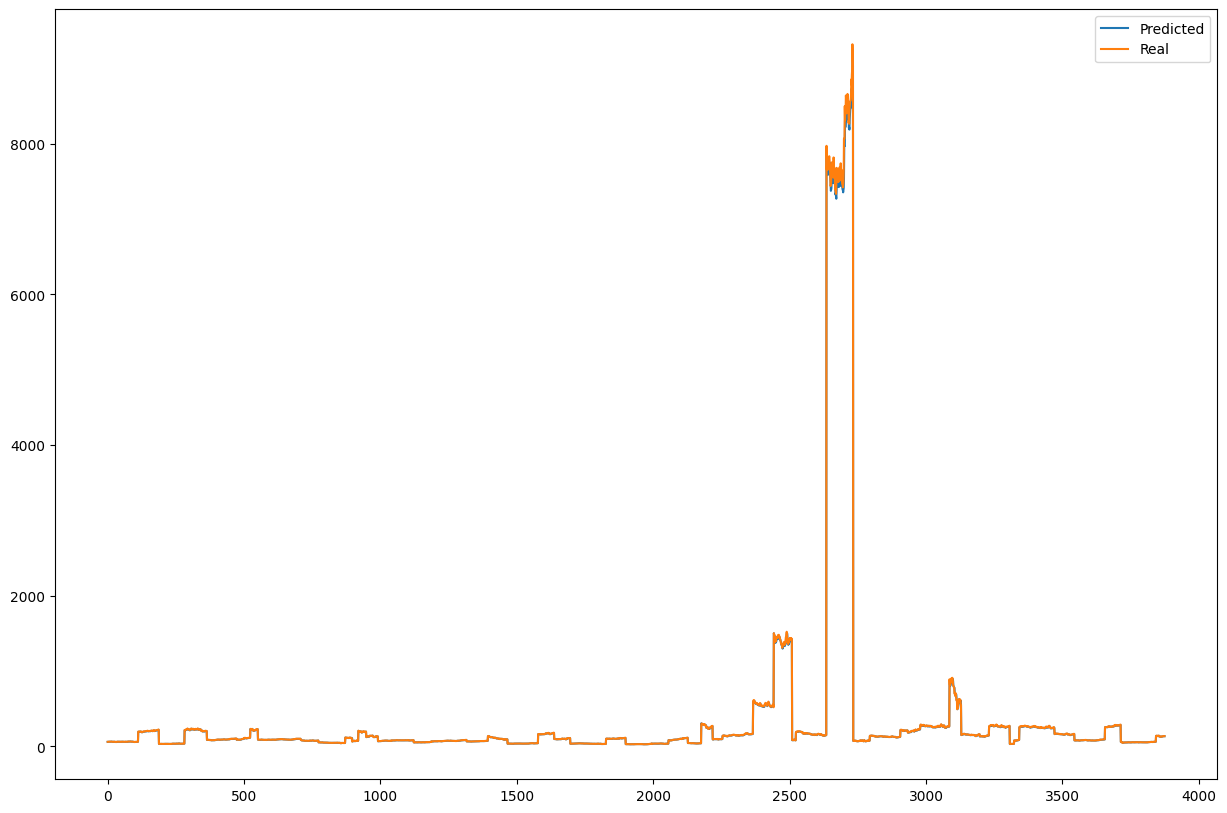

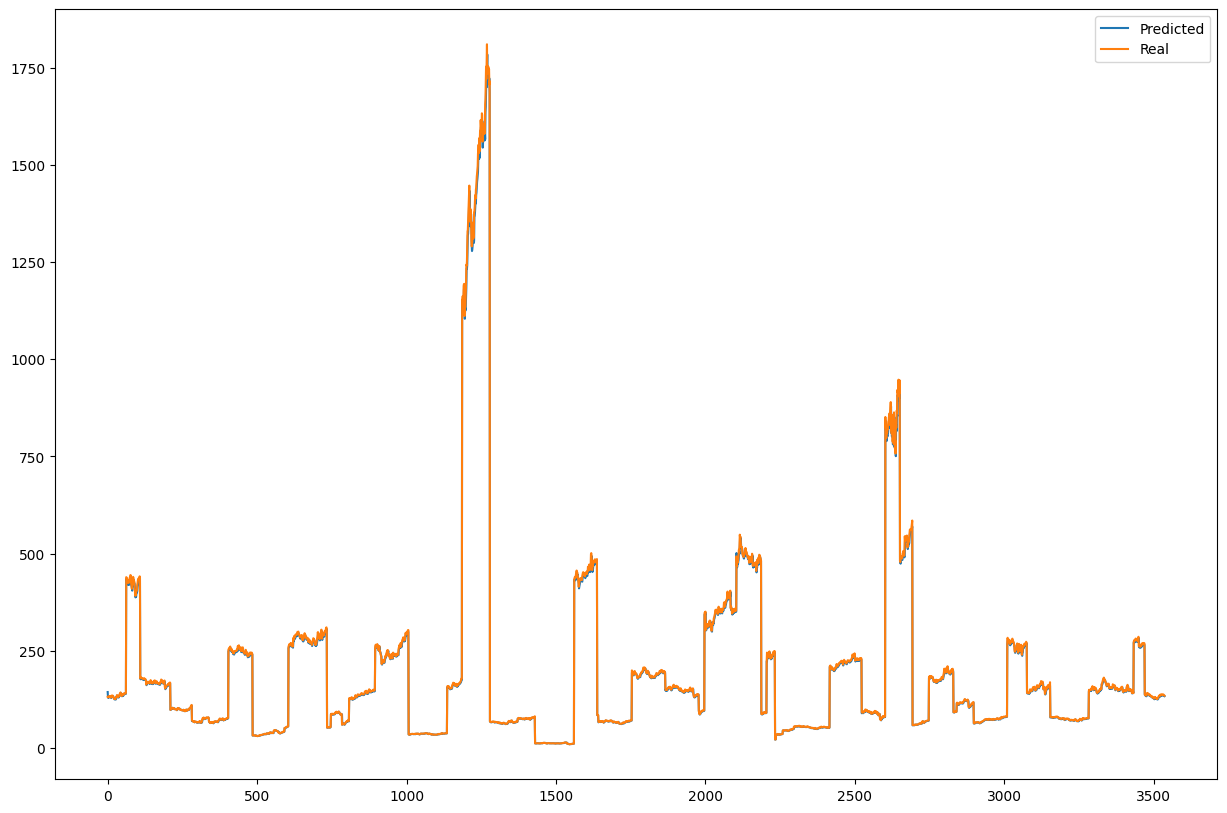

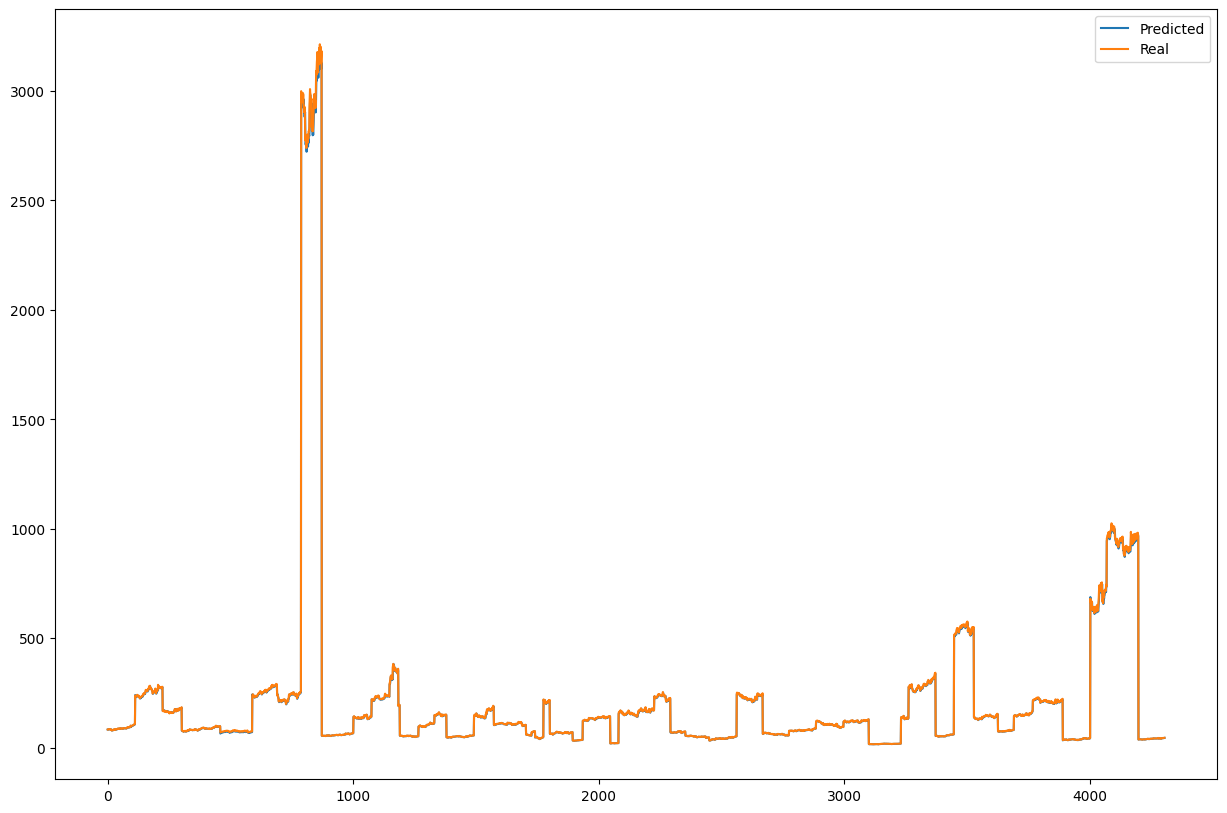

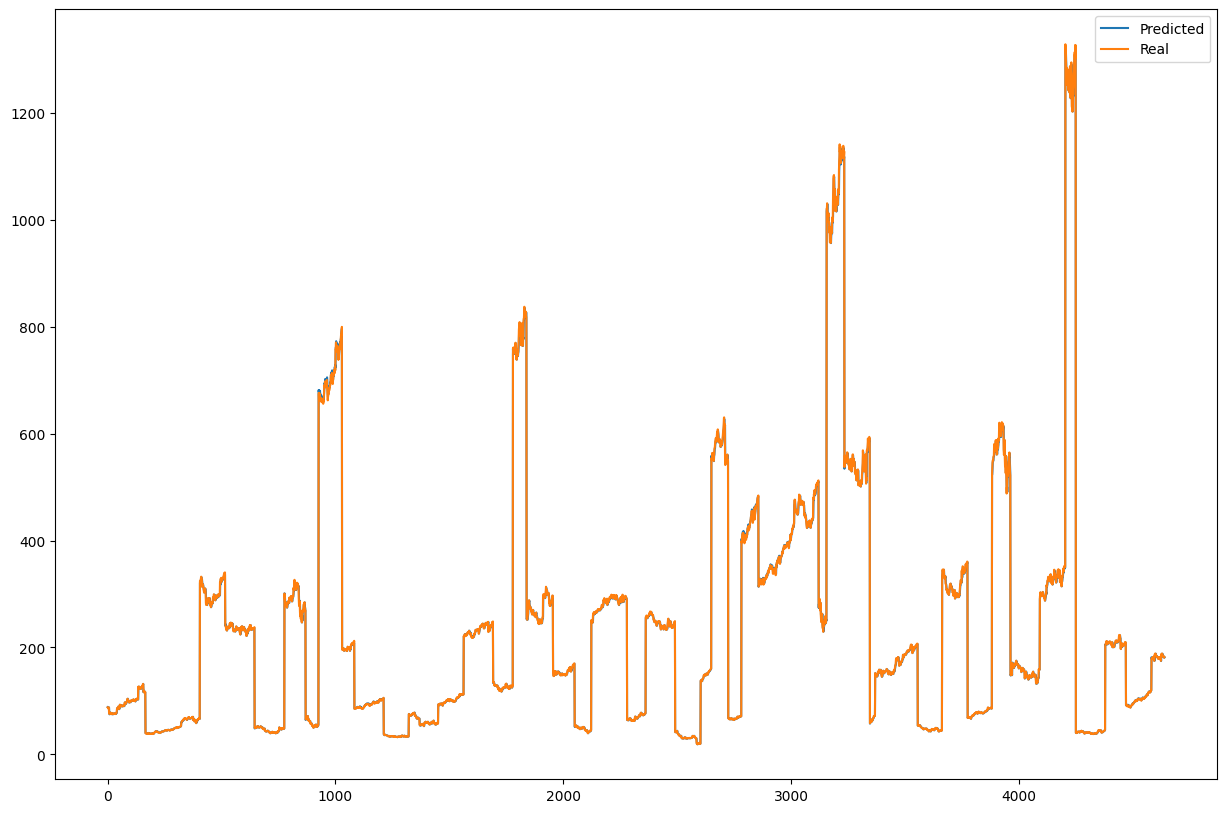

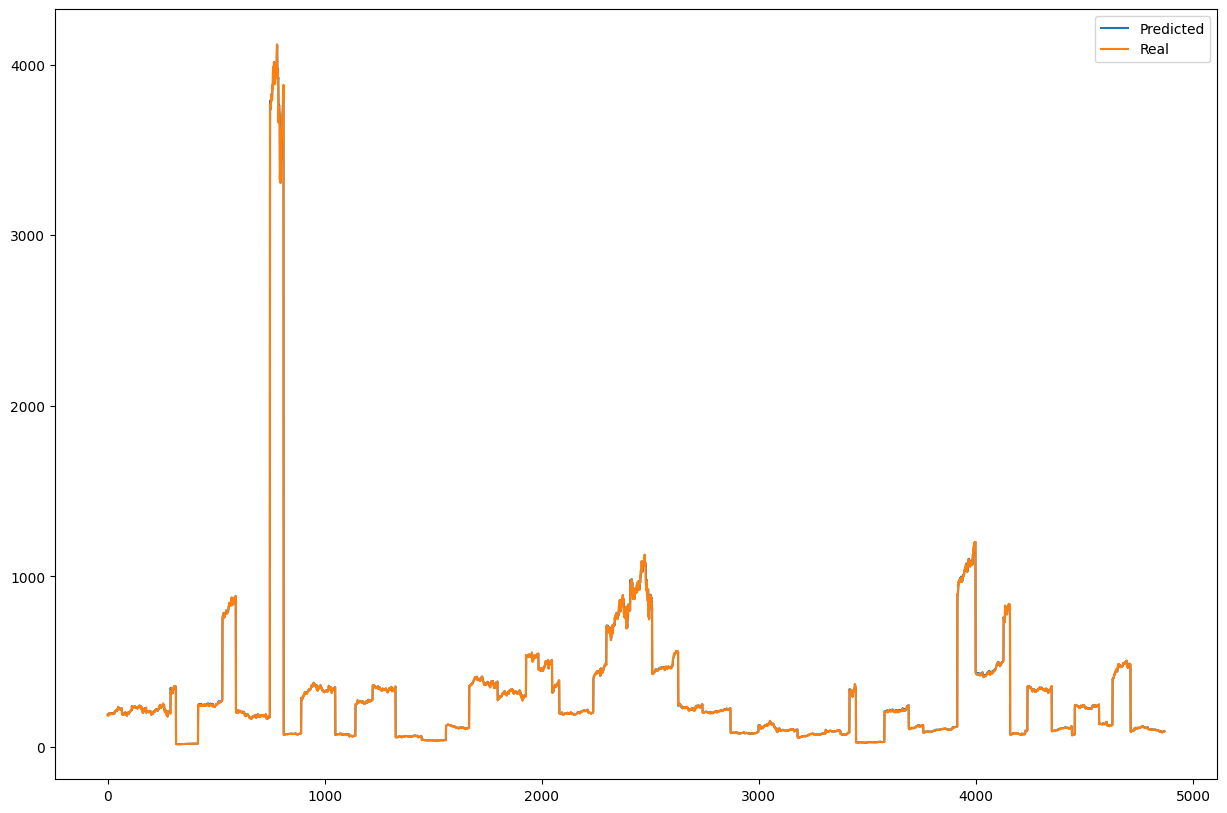

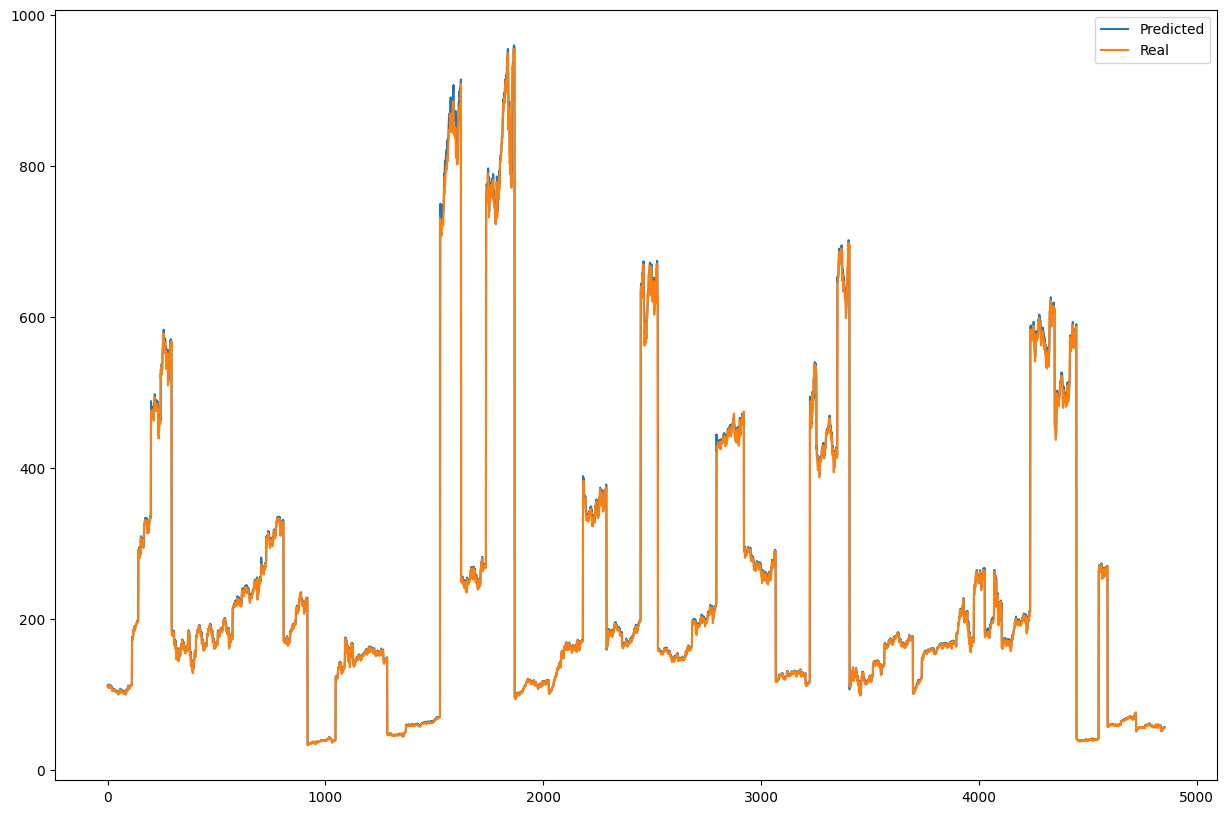

In [77]:
def TestData(listOfRankedTickers,metric,daysago,split):
    for listOfTickers in listOfRankedTickers:
        boxStart = listOfRankedTickers.index(listOfTickers)
        modelName = f'{boxStart*10}%-{(boxStart+1)*10}% quantile'
        print(modelName)
        modelOUT = load_model(f'models/{metric}/{modelName}.keras')
        big_acc_pred = np.array([]).reshape(-1)
        big_acc_real = np.array([]).reshape(-1)
        for ticker in listOfTickers:
            if ticker != 'CE':
                modelIN = modelOUT
                # print(ticker)
                data = DataPrep(ticker,daysago,split)
                X_test = data.X_test()
                Y_pred = modelIN.predict(X_test)
                Y_with_pred = np.append(data.Y_train(),Y_pred,axis=0)

                X = np.append(data.X_train(),data.X_test(),axis=0)
                fitted_with_pred = np.append(X.reshape((-1,daysago+1)),Y_with_pred,axis=1)
                fitted_with_pred = data.sc.inverse_transform(fitted_with_pred)
                acc_pred = fitted_with_pred[:,-1][data.split:] 
                fitted_real = data.sc.inverse_transform(data.fitted)
                acc_real = fitted_real[:,-1][data.split:]
                big_acc_pred = np.append(big_acc_pred,acc_pred,axis=0)
                big_acc_real = np.append(big_acc_real,acc_real,axis=0)
        
        avg_error = (np.sum(np.sqrt((big_acc_real - big_acc_pred)**2)))/len(big_acc_real)
        print(f"{modelName}'s abs avg error:{avg_error} USD")

        percentError = (np.sum(np.sqrt(((big_acc_pred - big_acc_real)/big_acc_real)**2))*100)/len(big_acc_pred)
        print(f"{modelName}'s %error:{percentError}%")

        #calculates the average error
        avg_error = (np.sum(big_acc_pred - big_acc_real))/len(big_acc_pred)
        print(f"{modelName}'s non-abs avg error:{avg_error} USD")

        big_acc_pred = pd.DataFrame(big_acc_pred)
        big_acc_real = pd.DataFrame(big_acc_real)
        big = pd.concat([big_acc_pred,big_acc_real],axis=1)
        big.columns = ['Predicted','Real']
        big.plot(figsize=(15,10))
    return big_acc_pred,big_acc_real
TestData(e,'marketCap',100,0.99)